# Imports

In [20]:
import sys

sys.path.append("..")
import pickle as pkl
from dataclasses import asdict, is_dataclass

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
from dacite import from_dict
from ipywidgets import interact

from calibration.benchmark.benchmark_result import (
    BenchmarkResult,
    calc_error,
    results_into_df,
)
from calibration.feature_detector.visualization import show_boards, show_corners
from calibration.feature_refiner.refine import refine_features_single
from calibration.feature_refiner.visualization import show_refined_corners
from calibration.projector.board import gen_checkerboard_grid
from calibration.projector.camera import Camera

# pio.renderers.default = "svg"
from calibration.projector.projector import Projector
from calibration.solver.optimization.solve import solve as solve_optimization
from calibration.solver.scaramuzza.solve import solve as solve_scaramuzza

# from calibration.solver.solve import solve

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
# with open("../babelcalib_results_overlay.pkl", "rb") as f:
with open("../babelcalib_results_None.pkl", "rb") as f:
    results = pkl.load(f)

In [3]:
df = results_into_df(results)

# EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 792 entries, 0 to 791
Data columns (total 27 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   input.ds_name                                 792 non-null    object 
 1   input.subds_name                              792 non-null    object 
 2   input.name                                    792 non-null    object 
 3   input.width                                   792 non-null    int64  
 4   input.height                                  792 non-null    int64  
 5   input.num_corners                             792 non-null    int64  
 6   input.encoding                                792 non-null    object 
 7   input.corners                                 792 non-null    object 
 8   input.image                                   792 non-null    object 
 9   features.board                                792 non-null    obj

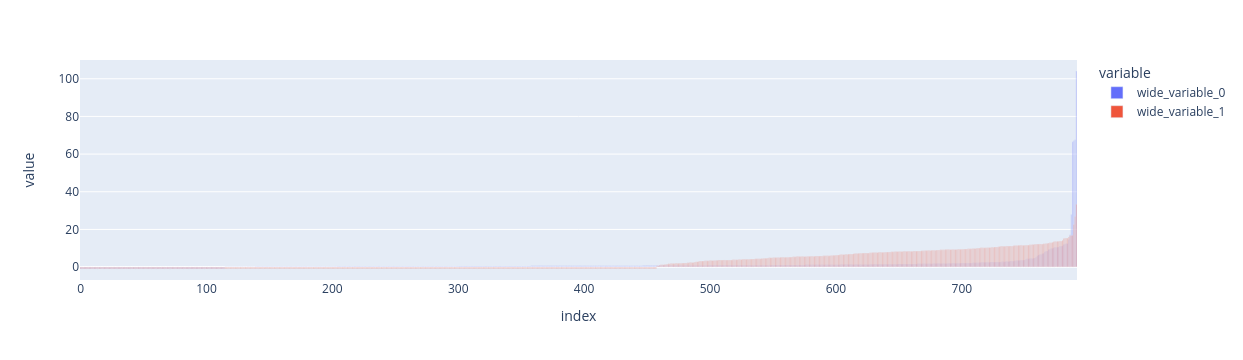

In [49]:
resultsO = sorted(
    [r for r in results if "Optimization" in r.errors],
    key=lambda r: r.errors["Optimization"],
)
resultsS = sorted(
    [r for r in results if "Scaramuzza" in r.errors],
    key=lambda r: r.errors["Scaramuzza"],
)

# df_ = df[~df["error"].isna()].sort_values("error")

px.bar(
    y=[
        sorted([r.errors["Optimization"] for r in resultsO]),
        sorted([r.errors["Scaramuzza"] for r in resultsS]),
    ],
    barmode="overlay",
)

In [50]:
(
    sum([r.errors["Optimization"] == -1 for r in results]),
    sum([r.errors["Scaramuzza"] == -1 for r in results]),
    sum([r.errors["Optimization"] > 10 for r in results]),
    sum([r.errors["Scaramuzza"] > 10 for r in results]),
    
    sum([-1<r.errors["Optimization"] < 10 for r in results]),
    sum([-1<r.errors["Scaramuzza"] < 10 for r in results]),
)

(115, 458, 19, 80, 658, 254)

In [41]:
px.histogram(
    x=[
        [
            r.errors["Optimization"]
            for r in results
            if "Optimization" in r.errors and r.errors["Optimization"] != -1
        ],
        [
            r.errors["Scaramuzza"]
            for r in results
            if "Scaramuzza" in r.errors and r.errors["Scaramuzza"] != -1
        ],
    ],
    barmode="overlay",
)

ValueError: All arguments should have the same length. The length of argument `wide_variable_1` is 357, whereas the length of  previously-processed arguments ['wide_variable_0'] is 668

In [34]:
results_ = sorted(
    [r for r in results if "Optimization" in r.errors],
    key=lambda r: r.errors["Optimization"],
)

In [35]:
@interact
def f(i=(0, len(results)), solver=["Optimization", "Scaramuzza", "Live optimize"]):
    r = results_[i]
    w, h = r.input.image.size

    print(f"{i}, error_Optim={r.errors['Optimization']}")

    match solver:
        case "Optimization" | "Scaramuzza":
            try:
                proj = r.predictions[solver]
                error = r.errors[solver]
            except KeyError:
                print(f"Cannot get {solver} from {r.predictions.keys()}")
        case "Live optimize":
            proj, hist = solve_optimization(
                r.features.corners,
                r.features.board,
                Camera(resolution=np.array(r.input.image.size)),
            )
            ret = proj

            px.line(hist).show()
            error = calc_error(proj, r.features)
        case _:
            raise NotImplementedError

    print(f"Error {solver}: {error}")

    assert r.features is not None

    # fig1 = show_boards(
    #     r.input.image, r.features.corners, r.features.board
    # ).update_layout(height=h, width=w)
    # display(fig1)

    try:
        max_point_img_space = np.r_[proj.camera.resolution, 1]
        max_point = np.linalg.inv(proj.camera.intrinsic_matrix) @ max_point_img_space
        max_r = float(np.linalg.norm(max_point[:2]))
        corners_ = proj.project(r.features.board, max_r * 10)
        # corners_ = r.prediction.project(r.features.board, 100)
        # px.scatter(
        #     corners_,
        #     x=0,
        #     y=1,
        #     title="Projected corners",
        #     range_x=[0, w],
        #     range_y=[0, h],
        #     # height=h,
        #     # width=w,
        # ).update_yaxes(autorange="reversed")
        # px.scatter(
        #     r.features.corners,
        #     x=0,
        #     y=1,
        #     title="Original corners",
        #     color=range(r.features.corners.shape[0]),
        #     range_x=[0, w],
        #     range_y=[0, h],
        #     # height=h,
        #     # width=w,
        # ).update_yaxes(autorange="reversed")
        show_boards(r.input.image, corners_, r.features.board).update_layout(
            height=h, width=w, title="Projected corners"
        ).show("svg")
    except ValueError:
        print("Cannot project")
    px.scatter(
        r.features.board,
        x=0,
        y=1,
        color=range(r.features.board.shape[0]),
        title="Original board",
        # height=h,
        # width=w,
    ).show("svg")
    board_ = proj.backproject(r.features.corners)
    px.scatter(
        board_,
        x=0,
        y=1,
        title="Backprojected board",
        # height=h,
        # width=w,
    ).show("svg")
    # display(
    #     # px.scatter(
    #     #     r.features.corners,
    #     #     x=0,
    #     #     y=1,
    #     #     title="Original corners",
    #     #     color=range(r.features.corners.shape[0]),
    #     #     range_x=[0, w],
    #     #     range_y=[0, h],
    #     #     # height=h,
    #     #     # width=w,
    #     # ).update_yaxes(autorange="reversed")
    #     show_boards(r.input.image, r.features.corners, r.features.board).update_layout(
    #         height=h, width=w, title="Original corners"
    #     )
    # )

    print(proj.R)
    print(proj.t)
    print(proj.lambdas)

    r_ = refine_features_single(r)
    show_refined_corners(
        np.array(r_.input.image),
        r_.refined_features.corners,
        r_.refined_features.board,
        r_.new_board_mask,
        r_.responses,
    ).update_layout(height=h, width=w, title="Refined").show()

interactive(children=(IntSlider(value=396, description='i', max=792), Dropdown(description='solver', options=(…